In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate
import math
from numpy import mean, std, sqrt
#from pycaret.regression import *
import torch
import torch.nn as nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
time_start = datetime.now()

In [ ]:
## setting the start and end date
start_date = '2000-01-01'
end_date = datetime.today()

## Data Preprocessing

In [ ]:
# Define the currency pair symbol for GBP to BDT
currency_pair = 'USDBDT=X'
# Fetch exchange rate data from Yahoo Finance
data = yf.download(currency_pair, start=start_date, end=end_date)
# Display the fetched data
print(data)

data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2002-04-01   57.250000   57.500000   57.000000   57.250000   57.250000       0
2003-01-02   57.900002   58.150002   57.650002   57.900002   57.900002       0
2003-04-21   58.200001   58.450001   57.950001   58.200001   58.200001       0
2003-12-01   56.612000   56.612000   56.612000   56.612000   56.612000       0
2003-12-02   56.706001   56.706001   56.706001   56.706001   56.706001       0
...                ...         ...         ...         ...         ...     ...
2024-05-06  107.837265  108.080009  107.837265  107.883858  107.883858       0
2024-05-07  108.047409  108.096809  108.047409  108.080009  108.080009       0
2024-05-08  108.290421  108.290421  108.101318  108.096809  108.096809       0
2024-05-09  108.136032  115.349495  108.136032  108.101318  108.101318       0
2024-05-10  116.010002  116.010002  116.010002  116.

In [ ]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,5321,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.0
mean,2014-02-22 20:24:02.435632384,76.872425,77.051662,76.759895,76.870658,76.870658,0.0
min,2002-04-01 00:00:00,56.456001,56.456001,56.456001,56.456001,56.456001,0.0
25%,2009-01-14 00:00:00,67.666000,67.703003,67.625999,67.655998,67.655998,0.0
50%,2014-02-25 00:00:00,76.511002,76.578003,76.364998,76.417999,76.417999,0.0
75%,2019-04-04 00:00:00,82.838997,83.112000,82.772903,82.928001,82.928001,0.0
max,2024-05-10 00:00:00,116.010002,116.010002,116.010002,116.980003,116.980003,0.0
std,NaN,11.559864,11.642141,11.516034,11.561394,11.561394,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5321 entries, 0 to 5320
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5321 non-null   datetime64[ns]
 1   Open       5321 non-null   float64       
 2   High       5321 non-null   float64       
 3   Low        5321 non-null   float64       
 4   Close      5321 non-null   float64       
 5   Adj Close  5321 non-null   float64       
 6   Volume     5321 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 291.1 KB


## Data Visualization

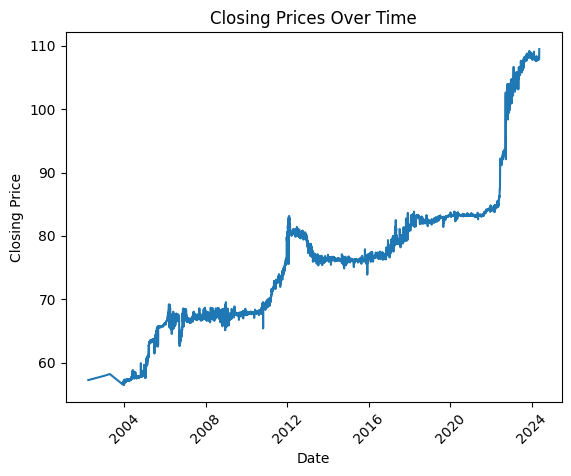

In [ ]:
# Plotting the closing prices
plt.plot(data['Date'] ,data['Close'])
plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
#plt.xticks([])
plt.xticks(rotation=45)
plt.savefig('USD to BDT closing price')
plt.show()

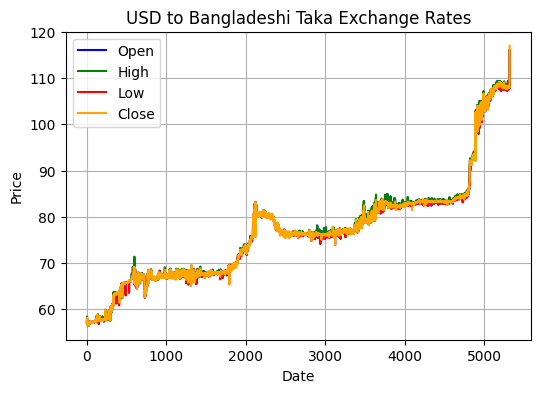

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(data.index, data['Open'], label='Open', color='blue')
plt.plot(data.index, data['High'], label='High', color='green')
plt.plot(data.index, data['Low'], label='Low', color='red')
plt.plot(data.index, data['Close'], label='Close', color='orange')

plt.title('USD to Bangladeshi Taka Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Splitting of data

In [ ]:
# Defining dataset for training, test and validation
feature_data_set = data

train_data_size = int(len(feature_data_set) * 0.80)  ## 80% dataset for training ##
test_data_size = int(len(feature_data_set) * 0.10)   ## 10% dataset for training ##
val_data_size = len(feature_data_set) - train_data_size - test_data_size  ## Validation dataset ##

# Split the data into training, testing, and validation sets
train_data = feature_data_set.iloc[:train_data_size]
validation_data = feature_data_set.iloc[train_data_size: train_data_size + test_data_size]
test_data = feature_data_set.iloc[train_data_size + val_data_size:]

# Print the shapes of the split sets
print(train_data.shape, validation_data.shape, test_data.shape)

(4256, 7) (532, 7) (532, 7)


In [ ]:
train_filter_data = train_data.filter(['Adj Close'])
train_data_set = train_filter_data.values

test__filter_data = test_data.filter(['Adj Close'])
test_data_set = test__filter_data.values

validation_filter_data = validation_data.filter(['Adj Close'])
validation_data_set = validation_filter_data.values

train_data_set.shape, test_data_set.shape, validation_data_set.shape

((4256, 1), (532, 1), (532, 1))

In [ ]:
## scaling of data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

Scaled_train_data_set = scaler.fit_transform(train_data_set)
Scaled_val_data_set = scaler.fit_transform(validation_data_set)
Scaled_test_data_set = scaler.fit_transform(test_data_set)

In [ ]:
## data spliting into x and y train
X_train = []
y_train = []

step_index = 30

for index in range(len(train_data) - step_index):
    X_train.append(Scaled_train_data_set[index:index + step_index, 0])
    y_train.append(Scaled_train_data_set[step_index + index, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert to NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match deep learning models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0],1)

# Print the reshaped data
print(X_train.shape , y_train.shape)

(4226, 30, 1) (4226, 1)


In [ ]:
## data spliting into x and y validate
X_Val = []
y_Val = []

for index in range(len(validation_data)-step_index):
    X_Val.append(Scaled_val_data_set[index : index + step_index, 0])
    y_Val.append(Scaled_val_data_set[step_index + index, 0])

X_Val, y_Val = np.array(X_Val), np.array(y_Val)

# Covert to NumPy array
X_Val = np.array(X_Val)
y_Val = np.array(y_Val)

# Reshaped input data to match with deep learning model
y_Val = y_Val.reshape(y_Val.shape[0] , 1)
X_Val = np.reshape(X_Val, (X_Val.shape[0], X_Val.shape[1], 1))

# Print the reshaped data
print(X_Val.shape, y_Val.shape)

(502, 30, 1) (502, 1)


In [ ]:
## data spliting into x and y test
X_test = []
y_test = []

for index in range(len(test_data) - step_index):
    X_test.append(Scaled_test_data_set[index : index + step_index, 0])
    y_test.append(Scaled_test_data_set[step_index + index, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert to NumPy array
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM input shape [samples, timesteps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test=y_test.reshape(y_test.shape[0],1)

# Print the reshaped data
print(X_test.shape, y_test.shape)

(502, 30, 1) (502, 1)


In [ ]:
def root_mean_square_error(y_true, y_pred):
    """
    Calculate Root Mean Square Error (RMSE).

    Parameters:
        y_true (array-like): The ground truth (actual) values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The root mean square error (RMSE) value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
        y_true (array-like): The ground truth (actual) values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The mean absolute percentage error (MAPE) value.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_square_error(y_true, y_pred):
    """
    Calculate Mean Square Error (MSE).

    Parameters:
        y_true (array-like): The ground truth (actual) values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The mean square error (MSE) value.
    """
    return np.mean((y_true - y_pred) ** 2)

## function defining

**GRU LSTM Model Fitting**

Epoch [1/30], Train Loss: 0.0076, Validation Loss: 0.3054
Epoch [2/30], Train Loss: 0.0296, Validation Loss: 0.2210
Epoch [3/30], Train Loss: 0.0338, Validation Loss: 0.1737
Epoch [4/30], Train Loss: 0.0297, Validation Loss: 0.1265
Epoch [5/30], Train Loss: 0.0201, Validation Loss: 0.0724
Epoch [6/30], Train Loss: 0.0098, Validation Loss: 0.0191
Epoch [7/30], Train Loss: 0.0014, Validation Loss: 0.0167
Epoch [8/30], Train Loss: 0.0024, Validation Loss: 0.0156
Epoch [9/30], Train Loss: 0.0021, Validation Loss: 0.0023
Epoch [10/30], Train Loss: 0.0003, Validation Loss: 0.0020
Epoch [11/30], Train Loss: 0.0003, Validation Loss: 0.0022
Epoch [12/30], Train Loss: 0.0003, Validation Loss: 0.0019
Epoch [13/30], Train Loss: 0.0003, Validation Loss: 0.0021
Epoch [14/30], Train Loss: 0.0003, Validation Loss: 0.0019
Epoch [15/30], Train Loss: 0.0003, Validation Loss: 0.0020
Epoch [16/30], Train Loss: 0.0003, Validation Loss: 0.0018
Epoch [17/30], Train Loss: 0.0003, Validation Loss: 0.0019
Epoch 

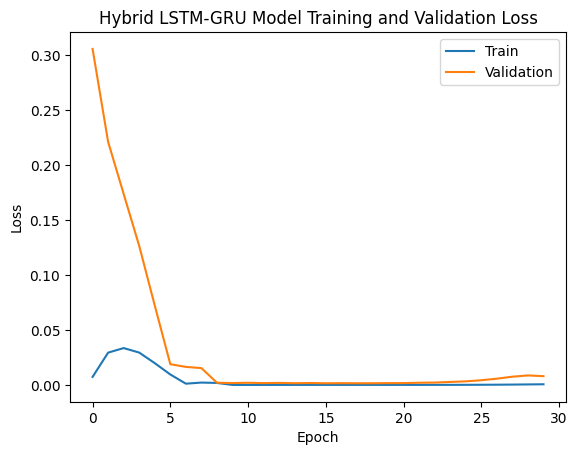

In [ ]:
# Define the hybrid GRU-LSTM model
class HybridGRULSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HybridGRULSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out[:, -1, :].unsqueeze(1))  # Taking only the last output of LSTM
        out = self.fc(gru_out[:, -1, :])
        return out

# Data preparation
# Assuming you have already split your data into X_train, y_train, X_Val, y_Val, X_test, y_test

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_val_torch = torch.tensor(X_Val, dtype=torch.float32)
y_val_torch = torch.tensor(y_Val, dtype=torch.float32)

# Model initialization
input_size = 1  # Assuming input is univariate time series
hidden_size = 64
output_size = 1
model = HybridGRULSTM(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training the model
num_epochs = 30
batch_size = 32
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    model.train()
    for i in range(0, len(X_train_torch), batch_size):
        inputs = X_train_torch[i:i+batch_size]
        targets = y_train_torch[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    train_loss = epoch_train_loss / (len(X_train_torch) / batch_size)
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_torch)
        val_loss = criterion(val_outputs, y_val_torch).item()
        val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting the loss
plt.plot(range(num_epochs), train_losses, label='Train')
plt.plot(range(num_epochs), val_losses, label='Validation')
plt.title('Hybrid LSTM-GRU Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Hybrid_LSTM_GRU_Model_Loss.png')
plt.show()

In [ ]:
# Get predictions for the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_torch)
hybrid_predictions_val = val_outputs.numpy()

# Inverse transform the predictions and ground truth
hybrid_predictions_val_inv = scaler.inverse_transform(hybrid_predictions_val)
y_val_inv = scaler.inverse_transform(y_Val)

# Calculate RMSE
rmse_val = np.sqrt(mean_squared_error(y_val_inv, hybrid_predictions_val_inv))
print("Validation RMSE:", rmse_val)

# Calculate MAPE
mape_val = mean_absolute_percentage_error(y_val_inv, hybrid_predictions_val_inv)
print("Validation MAPE:", mape_val)

# Calculate MSE
mse_val = mean_square_error(y_val_inv, hybrid_predictions_val_inv)
print("Validation MSE:", mse_val)

Validation RMSE: 2.9362943317211903
Validation MAPE: 2.37997341949004
Validation MSE: 8.621824402497992


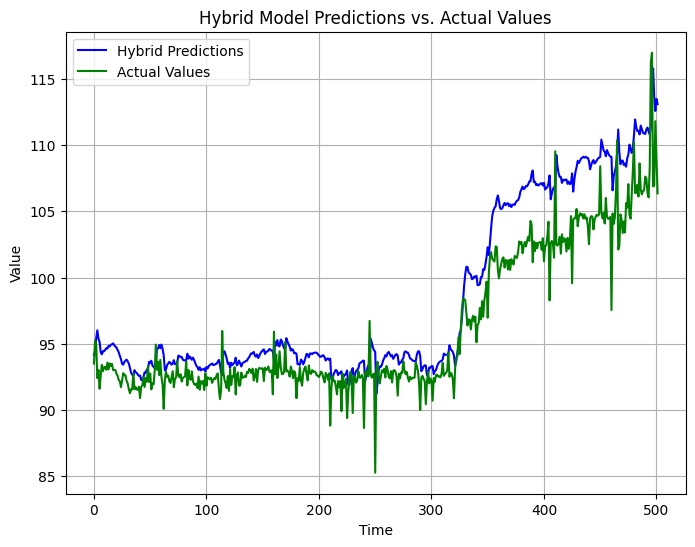

In [ ]:
x = range(len(hybrid_predictions_val))

plt.figure(figsize=(8, 6))
plt.plot(x, hybrid_predictions_val_inv, label='Hybrid Predictions', color='blue')
plt.plot(x, y_val_inv, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.savefig('Hybrid_Model_Predictions_vs_Actual_Values.png')
plt.show()

**GRU LSTM Model Testing**

In [ ]:
# Get predictions for the testing set
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
hybrid_predictions_test = test_outputs.numpy()

# Inverse transform the predictions and ground truth
hybrid_predictions_test_inv = scaler.inverse_transform(hybrid_predictions_test)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE for testing set
rmse_test = np.sqrt(mean_squared_error(y_test_inv, hybrid_predictions_test_inv))
print("Testing RMSE:", rmse_test)

# Calculate MAPE for testing set
mape_test = mean_absolute_percentage_error(y_test_inv, hybrid_predictions_test_inv)
print("Testing MAPE:", mape_test)

# Calculate MSE for testing set
mse_test = mean_square_error(y_test_inv, hybrid_predictions_test_inv)
print("Testing MSE:", mse_test)

Testing RMSE: 3.9188813212146956
Testing MAPE: 3.516735642137761
Testing MSE: 15.357630809765439


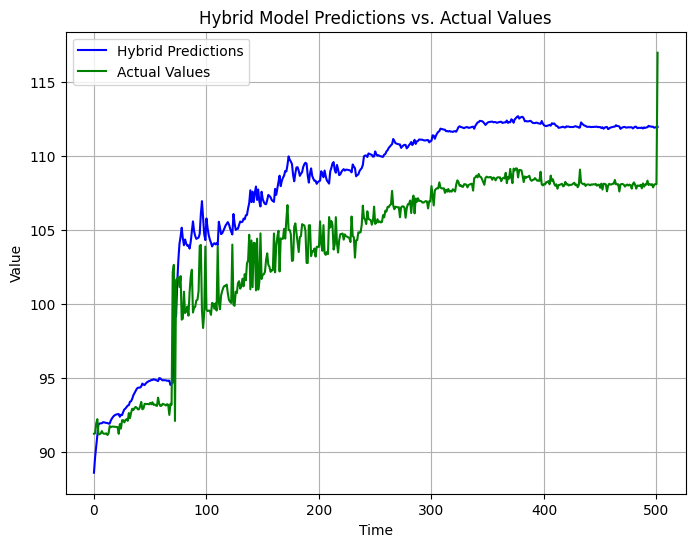

In [ ]:
x = range(len(hybrid_predictions_test))

plt.figure(figsize=(8, 6))
plt.plot(x, hybrid_predictions_test_inv, label='Hybrid Predictions', color='blue')
plt.plot(x, y_test_inv, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.savefig('Hybrid_Model_Predictions_vs_Actual_Values.png')
plt.show()

**Hybrid GRU Model Prediction**

In [ ]:
hybrid_predictions_test_inv

array([[ 88.61246 ],
       [ 89.6519  ],
       [ 90.40221 ],
       [ 91.19387 ],
       [ 91.87548 ],
       [ 91.93687 ],
       [ 91.94455 ],
       [ 91.95522 ],
       [ 92.02426 ],
       [ 92.01523 ],
       [ 91.99102 ],
       [ 91.97435 ],
       [ 91.97155 ],
       [ 91.924034],
       [ 91.93446 ],
       [ 92.146355],
       [ 92.2799  ],
       [ 92.38993 ],
       [ 92.469055],
       [ 92.5191  ],
       [ 92.549576],
       [ 92.56676 ],
       [ 92.57572 ],
       [ 92.39329 ],
       [ 92.523315],
       [ 92.50531 ],
       [ 92.72014 ],
       [ 92.88716 ],
       [ 92.947014],
       [ 93.04892 ],
       [ 93.14998 ],
       [ 93.17355 ],
       [ 93.406876],
       [ 93.43735 ],
       [ 93.605934],
       [ 93.842834],
       [ 93.98103 ],
       [ 94.13001 ],
       [ 94.27198 ],
       [ 94.3524  ],
       [ 94.3612  ],
       [ 94.36335 ],
       [ 94.44253 ],
       [ 94.6315  ],
       [ 94.56657 ],
       [ 94.53199 ],
       [ 94.63429 ],
       [ 94.7

In [ ]:
import datetime
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], hybrid_predictions_test_inv[-14:]):
    print(f"{date.date()}: {price}")

2024-05-11: [111.86245]
2024-05-12: [111.934845]
2024-05-13: [111.902885]
2024-05-14: [111.93409]
2024-05-15: [111.948784]
2024-05-16: [112.04263]
2024-05-17: [111.999466]
2024-05-18: [111.99913]
2024-05-19: [111.977615]
2024-05-20: [111.98366]
2024-05-21: [111.91563]
2024-05-22: [111.94183]
2024-05-23: [111.96085]
2024-05-24: [111.9731]


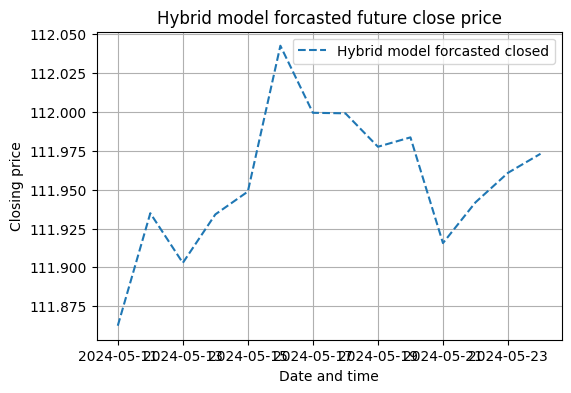

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], hybrid_predictions_test_inv[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.show()

**CNN model**

**Model Fitting**

Epoch [1/20], Train Loss: 0.0013
Epoch [2/20], Train Loss: 0.0095
Epoch [3/20], Train Loss: 0.0020
Epoch [4/20], Train Loss: 0.0008
Epoch [5/20], Train Loss: 0.0009
Epoch [6/20], Train Loss: 0.0007
Epoch [7/20], Train Loss: 0.0007
Epoch [8/20], Train Loss: 0.0007
Epoch [9/20], Train Loss: 0.0007
Epoch [10/20], Train Loss: 0.0007
Epoch [11/20], Train Loss: 0.0006
Epoch [12/20], Train Loss: 0.0006
Epoch [13/20], Train Loss: 0.0005
Epoch [14/20], Train Loss: 0.0006
Epoch [15/20], Train Loss: 0.0007
Epoch [16/20], Train Loss: 0.0007
Epoch [17/20], Train Loss: 0.0007
Epoch [18/20], Train Loss: 0.0007
Epoch [19/20], Train Loss: 0.0006
Epoch [20/20], Train Loss: 0.0006


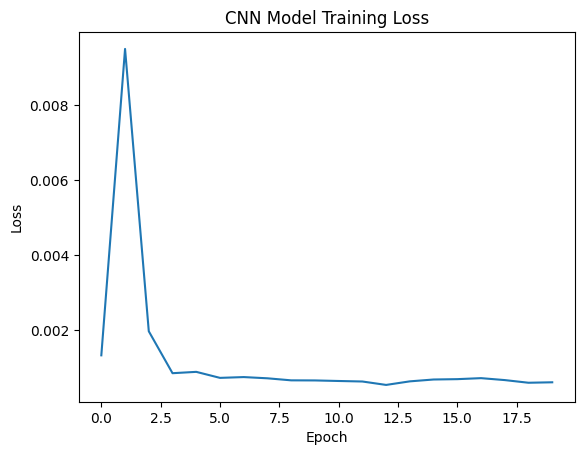

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * ((step_index - 2) // 2), 64)  # Adjust the input size based on your step_index
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Reshape the input data to match the CNN input shape [batch_size, in_channels, sequence_length]
X_train_torch = X_train_torch.permute(0, 2, 1)  # Rearrange dimensions to match Conv1d expectation

# Training loop
num_epochs = 20
batch_size = 16
train_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    for i in range(0, len(X_train_torch), batch_size):
        inputs = X_train_torch[i:i+batch_size]
        targets = y_train_torch[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets.unsqueeze(1))  # Ensure targets have the same shape as outputs
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    train_loss = epoch_train_loss / (len(X_train_torch) / batch_size)
    train_losses.append(train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

# Plotting the loss
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses)
plt.title('CNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## CNN Model performance in validation set

In [ ]:
# Convert validation data to PyTorch tensors
X_val_torch = torch.tensor(X_Val, dtype=torch.float32)
y_val_torch = torch.tensor(y_Val, dtype=torch.float32)

# Reshape the input data to match the CNN input shape [batch_size, in_channels, sequence_length]
X_val_torch = X_val_torch.permute(0, 2, 1)  # Rearrange dimensions to match Conv1d expectation

# Get predictions for the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_torch)
cnn_predictions_val = val_outputs.numpy()

# Calculate RMSE, MSE, and MAPE for validation set
cnn_predictions_val_inv = scaler.inverse_transform(cnn_predictions_val.reshape(-1, 1)).flatten()
y_val_inv = scaler.inverse_transform(y_Val)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Calculate RMSE for validation set
rmse_val = np.sqrt(mean_squared_error(y_val_inv, cnn_predictions_val_inv))
print("Validation RMSE:", rmse_val)

# Calculate MAPE for validation set
mape_val = mean_absolute_percentage_error(y_val_inv, cnn_predictions_val_inv)
print("Validation MAPE:", mape_val)

# Calculate MSE for validation set
mse_val = mean_squared_error(y_val_inv, cnn_predictions_val_inv)
print("Validation MSE:", mse_val)

Validation RMSE: 2.2185079596658714
Validation MAPE: 0.019535198259629526
Validation MSE: 4.921777567100827


## CNN MODEL PERFORMANCE USING TEST SET

In [ ]:
# Convert test data to PyTorch tensors
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Reshape the input data to match the CNN input shape [batch_size, in_channels, sequence_length]
X_test_torch = X_test_torch.permute(0, 2, 1)  # Rearrange dimensions to match Conv1d expectation

# Get predictions for the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
cnn_predictions_test = test_outputs.numpy()

# Calculate RMSE, MSE, and MAPE for test set
cnn_predictions_test_inv = scaler.inverse_transform(cnn_predictions_test.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test_inv, cnn_predictions_test_inv))
print("Test RMSE:", rmse_test)

# Calculate MAPE for test set
mape_test = mean_absolute_percentage_error(y_test_inv, cnn_predictions_test_inv)
print("Test MAPE:", mape_test)

# Calculate MSE for test set
mse_test = mean_squared_error(y_test_inv, cnn_predictions_test_inv)
print("Test MSE:", mse_test)


Test RMSE: 2.688450721893371
Test MAPE: 0.023696622199806637
Test MSE: 7.227767284048987


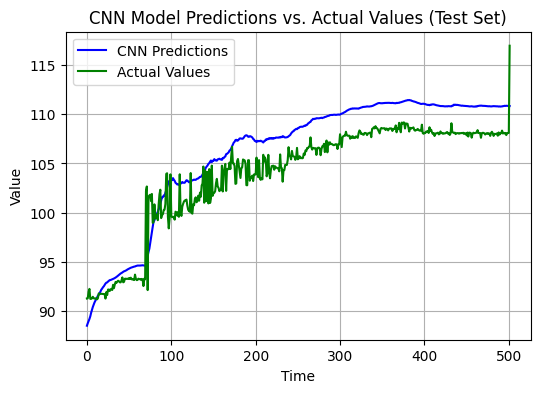

In [ ]:
# Plotting the predictions vs. actual values for the test set
x = range(len(cnn_predictions_test_inv))

plt.figure(figsize=(6, 4))
plt.plot(x, cnn_predictions_test_inv, label='CNN Predictions', color='blue')
plt.plot(x, y_test_inv, label='Actual Values', color='green')

plt.title('CNN Model Predictions vs. Actual Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
cnn_predictions_test_inv

array([ 88.47855 ,  88.72821 ,  88.93595 ,  89.16949 ,  89.43442 ,
        89.800255,  90.086   ,  90.385506,  90.6091  ,  90.846695,
        91.0202  ,  91.208336,  91.3572  ,  91.52553 ,  91.635826,
        91.80086 ,  91.94114 ,  92.14276 ,  92.25245 ,  92.391556,
        92.48598 ,  92.635086,  92.76613 ,  92.857056,  92.88465 ,
        92.97495 ,  93.045006,  93.120224,  93.12908 ,  93.16503 ,
        93.19591 ,  93.24189 ,  93.281334,  93.3265  ,  93.38078 ,
        93.441185,  93.509766,  93.58197 ,  93.66758 ,  93.7312  ,
        93.79931 ,  93.84249 ,  93.905876,  93.962   ,  94.01719 ,
        94.04783 ,  94.09141 ,  94.134926,  94.20176 ,  94.24815 ,
        94.30138 ,  94.331024,  94.3792  ,  94.409   ,  94.447945,
        94.471085,  94.49595 ,  94.51075 ,  94.55002 ,  94.57444 ,
        94.602165,  94.59877 ,  94.60449 ,  94.60317 ,  94.6157  ,
        94.6228  ,  94.62985 ,  94.61366 ,  94.60413 ,  94.5906  ,
        94.60341 ,  94.994255,  95.599365,  95.99822 ,  96.321

In [ ]:
import datetime
num_future_days = 14
lastest_date = pd.to_datetime(data['Date'].iat[-1])
# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]
# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], cnn_predictions_test_inv[-14:]):
    print(f"{date.date()}: {price}")

2024-05-11: 110.78836822509766
2024-05-12: 110.80168151855469
2024-05-13: 110.78530883789062
2024-05-14: 110.79930114746094
2024-05-15: 110.80162048339844
2024-05-16: 110.82998657226562
2024-05-17: 110.83660125732422
2024-05-18: 110.86438751220703
2024-05-19: 110.85125732421875
2024-05-20: 110.867919921875
2024-05-21: 110.85579681396484
2024-05-22: 110.85462188720703
2024-05-23: 110.8560562133789
2024-05-24: 110.84480285644531


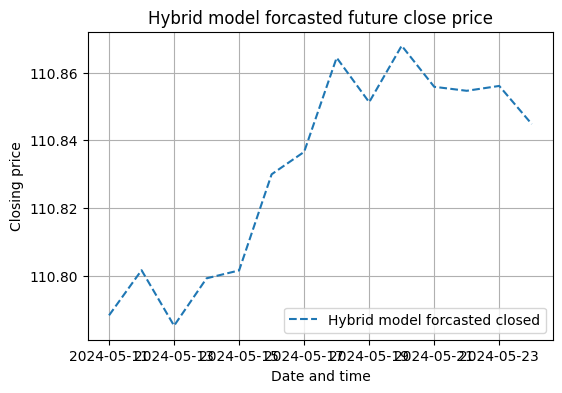

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], cnn_predictions_test_inv[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.savefig('USDBDT forecasting')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Create a sample DataFrame for USD to BDT exchange rates
dates = pd.date_range(start='2002-04-01', end='2024-04-04', freq='B')  # Business days
np.random.seed(42)
data = np.random.normal(loc=80, scale=5, size=len(dates))  # Simulate exchange rates around 80 BDT
exchange_rates = pd.DataFrame(data, index=dates, columns=['Close'])

# Simulate sentiment data
sentiment_data = np.random.uniform(-1, 1, size=len(dates))
sentiment_df = pd.DataFrame(sentiment_data, index=dates, columns=['Sentiment'])
# Merge the datasets
merged_df = exchange_rates.join(sentiment_df)
merged_df

,Close,Sentiment
2002-04-01,82.483571,0.089763
2002-04-02,79.308678,-0.432986
2002-04-03,83.238443,0.896850
2002-04-04,87.615149,0.684928
2002-04-05,78.829233,0.444747
...,...,...
2024-03-29,80.494669,-0.992978
2024-04-01,81.691787,-0.919961
2024-04-02,75.037110,-0.598298
2024-04-03,80.102086,-0.627983


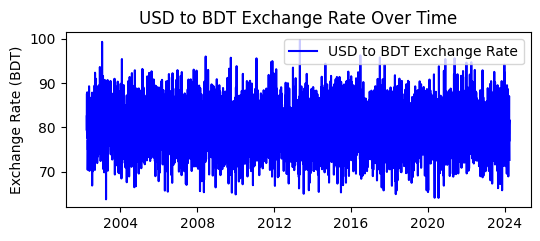

In [ ]:
# Visualizing the data
plt.figure(figsize=(6, 5))
# Plotting exchange rates
plt.subplot(2, 1, 1)
plt.plot(merged_df.index, merged_df['Close'], label='USD to BDT Exchange Rate', color='blue')
plt.title('USD to BDT Exchange Rate Over Time')
plt.ylabel('Exchange Rate (BDT)')
plt.legend()

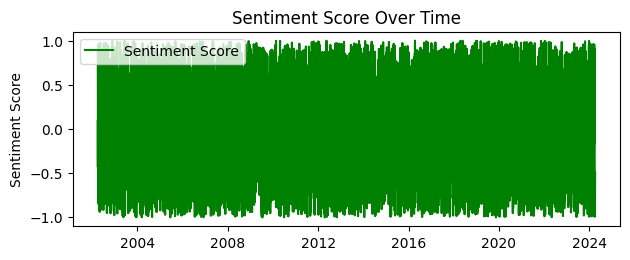

In [ ]:
# Plotting sentiment data
plt.subplot(2, 1, 2)
plt.plot(merged_df.index, merged_df['Sentiment'], label='Sentiment Score', color='green')
plt.title('Sentiment Score Over Time')
plt.ylabel('Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

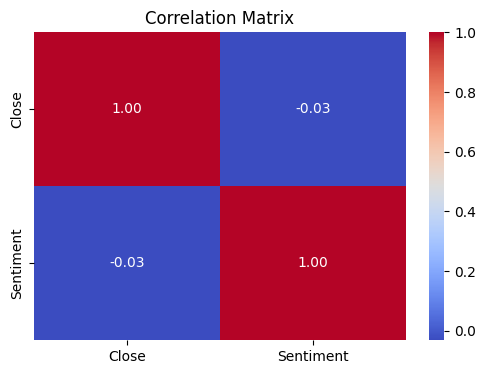

In [ ]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df)
# Prepare the data for modeling
X = merged_df[['Sentiment']]
y = merged_df['Close']

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 26.438918807475854
